## Prepare Data

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
%matplotlib inline

### Load data

In [2]:
df = pd.read_csv('Solar Power Plant Data.csv')
df.head()

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [3]:
# shape dataframe 
df.shape

(8760, 8)

In [4]:
# information about each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date-Hour(NMT)       8760 non-null   object 
 1   WindSpeed            8760 non-null   float64
 2   Sunshine             8760 non-null   int64  
 3   AirPressure          8760 non-null   float64
 4   Radiation            8760 non-null   float64
 5   AirTemperature       8760 non-null   float64
 6   RelativeAirHumidity  8760 non-null   int64  
 7   SystemProduction     8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 547.6+ KB


In [5]:
# statistical analysis
df.describe()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2.639823,11.180479,1010.361781,97.538493,6.978893,76.719406,684.746071
std,1.628754,21.171295,12.793971,182.336029,7.604266,19.278996,1487.454665
min,0.000000,0.000000,965.900000,-9.300000,-12.400000,13.000000,0.000000
25%,1.400000,0.000000,1002.800000,-6.200000,0.500000,64.000000,0.000000
50%,2.300000,0.000000,1011.000000,-1.400000,6.400000,82.000000,0.000000
75%,3.600000,7.000000,1018.200000,115.600000,13.400000,93.000000,464.249950
max,10.900000,60.000000,1047.300000,899.700000,27.100000,100.000000,7701.000000


In [6]:
# rename 'Date-Hour(NMT)' column to 'Datatime'
df.rename(columns = {'Date-Hour(NMT)' : 'Datetime'}, inplace = True)

In [7]:
# make Datatime column as an index and convert it to datatime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index,infer_datetime_format = True)

In [8]:
# show the first five rows
df.head()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
Datetime,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,0.0


## Exploratory Data Analysis

### Proudction over the Year

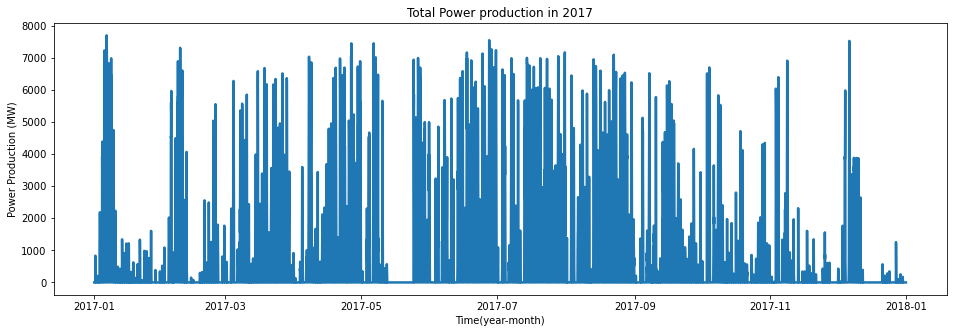

In [9]:
plt.figure(figsize=(16, 5))
sns.lineplot(x = df.index,
            y = 'SystemProduction',
            data = df, linewidth = 2.5)
plt.xlabel('Time(year-month)')
plt.ylabel('Power Production (MW)')
plt.title('Total Power production in 2017');

### correlation of each column with another column

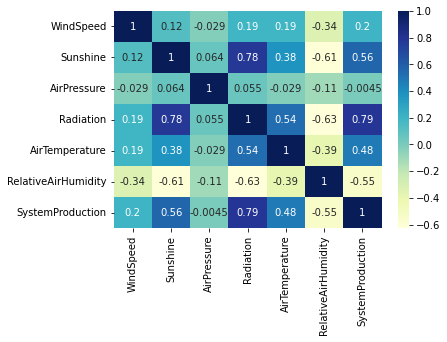

In [10]:
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);

### Visualizing the first week of system production

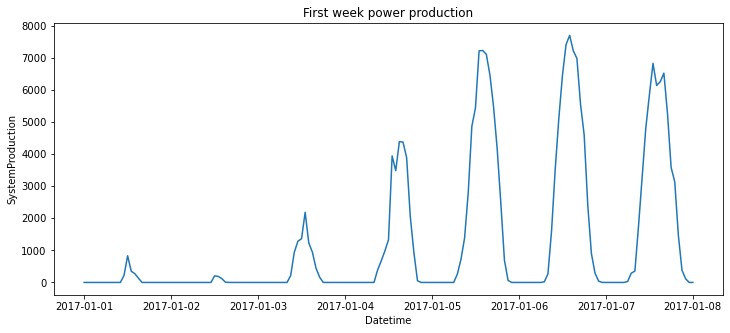

In [11]:
_ = df.loc[df.index <= '2017-01-08']
plt.subplots(figsize=(12, 5))
sns.lineplot(x = _.index, y = 'SystemProduction', data = _)
plt.title('First week power production');

In [12]:
# create time series features from the index 
def create_features(df):
   
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    return df
create_features(df)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,day_of_week,quarter,month,day_of_month,day_of_year,week_of_year
Datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0,0,6,1,1,1,1,52
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0,1,6,1,1,1,1,52
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0,2,6,1,1,1,1,52
2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0,3,6,1,1,1,1,52
2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,0.0,4,6,1,1,1,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,4.1,0,988.2,-4.8,-0.7,94,0.0,19,6,4,12,31,365,52
2017-12-31 20:00:00,2.1,0,987.3,-5.0,-0.3,95,0.0,20,6,4,12,31,365,52
2017-12-31 21:00:00,1.8,0,986.7,-5.3,0.2,93,0.0,21,6,4,12,31,365,52


### System Production of each hour over 24-hours

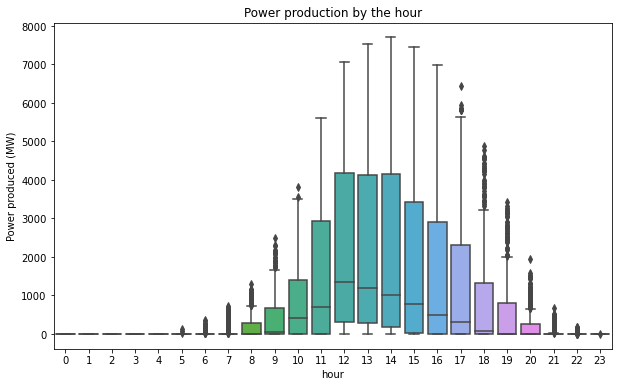

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x = 'hour',
           y = 'SystemProduction',
           data = df)
plt.ylabel('Power produced (MW)')
plt.title('Power production by the hour')
plt.show()

**Power production starts around 8:00 am and peaks around 14:00 hours, before dropping off again at 21:00 hours**

### System Production of each month

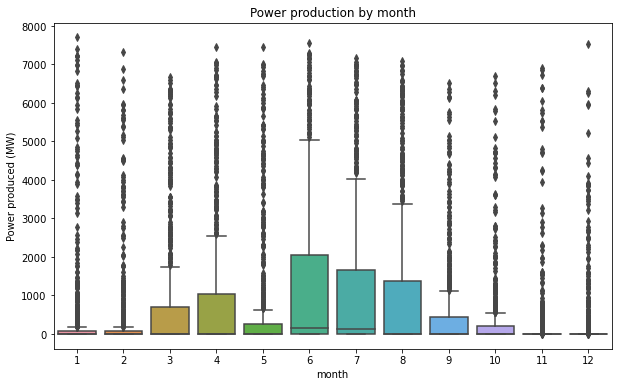

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x = 'month',
           y = 'SystemProduction',
           data = df)
plt.ylabel('Power produced (MW)')
plt.title('Power production by month')
plt.show()

- **System Production is lowest in November and December (because of Winter season)**
- **Power production is very high during the summer June, July and August**

## Buliding the model

In [15]:
# split data to train and test
train = df.loc[df.index < '2017-10-01']
test = df.loc[df.index >= '2017-10-01']

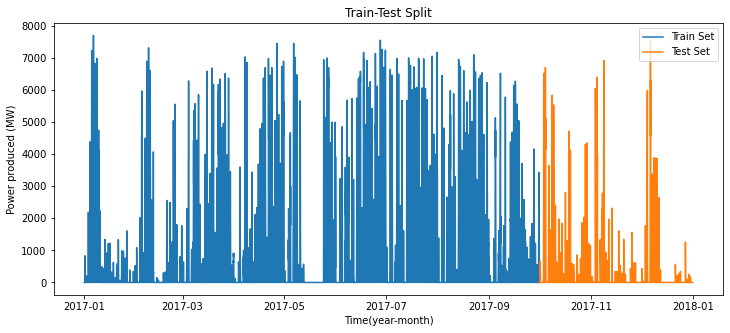

In [16]:
# Plot train and test data of system production
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x = train.index, y = 'SystemProduction', data = train)
sns.lineplot(x = test.index, y = 'SystemProduction', data = test)

plt.title('Train-Test Split')
plt.ylabel('Power produced (MW)')
plt.xlabel('Time(year-month)')
ax.legend(['Train Set', 'Test Set'])
plt.show();

In [17]:
# training set
X_train = train.drop(columns = ['SystemProduction'])
y_train = train['SystemProduction']

# test dataframe
X_test = test.drop(columns = ['SystemProduction'])
y_test = test['SystemProduction']

In [18]:
X_train.head()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,hour,day_of_week,quarter,month,day_of_month,day_of_year,week_of_year
Datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0,6,1,1,1,1,52
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,1,6,1,1,1,1,52
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,2,6,1,1,1,1,52
2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,3,6,1,1,1,1,52
2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,4,6,1,1,1,1,52


In [19]:
# types of each column
X_train.dtypes

WindSpeed              float64
Sunshine                 int64
AirPressure            float64
Radiation              float64
AirTemperature         float64
RelativeAirHumidity      int64
hour                     int64
day_of_week              int64
quarter                  int64
month                    int64
day_of_month             int64
day_of_year              int64
week_of_year            UInt32
dtype: object

In [20]:
# change type of week_of_year column from Uint to float
X_train['week_of_year'] = X_train['week_of_year'].astype(np.float64)
X_test['week_of_year'] = X_test['week_of_year'].astype(np.float64)

**we use XGboost regressor for predict the system production**

In [21]:
# choose some values of each parameters
parameters = {'n_estimators': [5, 10, 100, 1000],
             'max_depth': [2, 4, 6, 8],
             'learning_rate': [0.01, 0.1, 1],
              'max_leaves': [2, 4, 6, 8]
             }

In [22]:
model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [2, 4, 6, 8], 'max_leaves': [2, 4, 6, 8],
                         'n_estimators': [5, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [23]:
print('best parameters: ', clf.best_params_)
print('best score: ', clf.best_score_)

best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 1000}
best score:  -1100479.7386493231


In [24]:
parameters = {'learning_rate': [0.01], 
              'max_depth': [2], 
              'max_leaves': [2], 
              'n_estimators': [1000]}
model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01], 'max_depth': [2],
                         'max_leaves': [2], 'n_estimators': [1000]},
             scoring='neg_mean_squared_error')

In [25]:
# Predictions
y_preds = clf.predict(X_test)

In [26]:
# check MAE
print(mean_absolute_error(y_test, y_preds))

214.70608777865783


###  feature importance

In [27]:
reg = XGBRegressor(learning_rate= 0.01, 
              max_depth= 2, 
              max_leaves = 2, 
              n_estimators = 1000)
reg.fit(X_train, y_train)
print(reg.feature_importances_)

[0.00754434 0.01414702 0.02152656 0.49117908 0.09142839 0.03488938
 0.18607625 0.         0.00056145 0.02968055 0.08297654 0.02690915
 0.01308128]


### plot feature importance

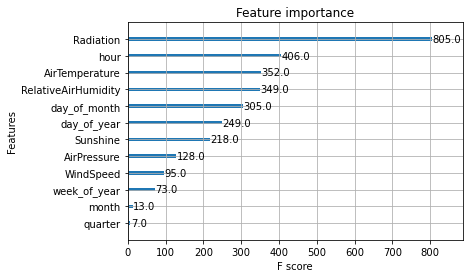

In [28]:
plot_importance(reg)
plt.show()

## Visualizing Predictions in test set

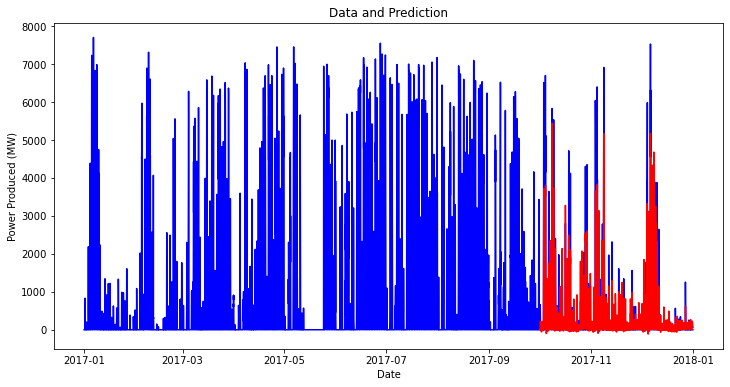

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(x= df.index, y = 'SystemProduction', data=df, color = 'blue') #test data 
sns.lineplot(x = X_test.index, y = y_preds, color = 'red') # predictions
plt.title('Data and Prediction')
plt.ylabel('Power Produced (MW)')
plt.xlabel('Date')
plt.show();

### Visualizing predictions of the first week with test data

In [30]:
# making a copy of test set
test_copy = test.copy()

# adding predictions to the dataframe
test_copy['predictions'] = y_preds

# slicing a week of the data set
f_week = test_copy.loc[(test_copy.index <= '2017-10-07')]

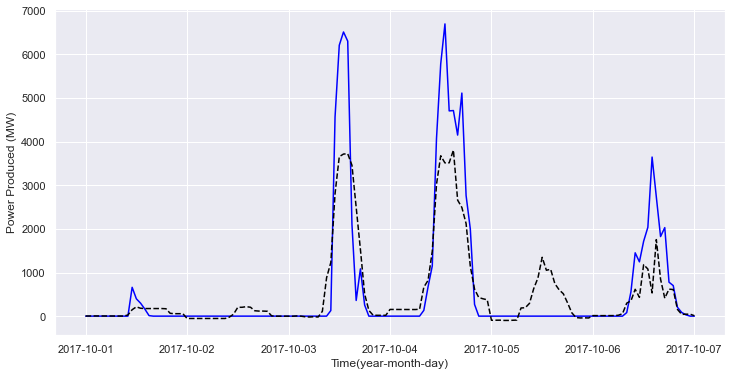

In [31]:
# Plot predictions and actual values
sns.set()
plt.figure(figsize=(12, 6))
sns.lineplot(data = f_week, x = f_week.index, y='SystemProduction', color = 'blue')                     # actual values
sns.lineplot(data = f_week, x = f_week.index, y = 'predictions', color = 'black', linestyle = 'dashed') # predicted values
plt.ylabel('Power Produced (MW)')
plt.xlabel('Time(year-month-day)')
plt.show();

### Visualizing the first month of predictions with test set

In [32]:
# slicing a week of the data set
f_month = test_copy.loc[(test_copy.index > '2017-10-31') & (test_copy.index < '2017-12-01')]

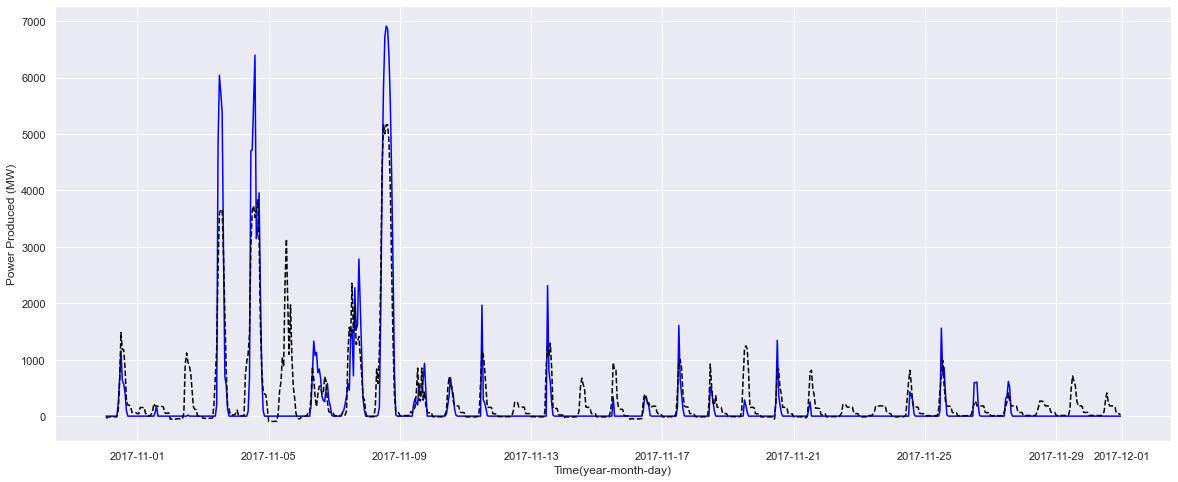

In [33]:
# Plot predictions and actual values
plt.figure(figsize=(20, 8))
sns.lineplot(data = f_month, x = f_month.index, y='SystemProduction', color = 'blue') # actual values
sns.lineplot(data = f_month, x = f_month.index, y = 'predictions', color = 'black', linestyle = 'dashed') # predicted values
plt.ylabel('Power Produced (MW)')
plt.xlabel('Time(year-month-day)')
plt.show();

================================================================================================================